# Generating negative samples based on scoring gradients

\> Generating negative samples based target swapping on top FIRE or SAE difference magnitudes creates nonexistant specificity for the RPI107 evaluation set <br/>
\> Hypothesize that this is because generated negative samples are too obvious, which causes model to fail on edge cases <br/>
\> To test, we'll be generating negative samples based on gradiented FIRE/SAE difference magnitue scores <br/>
\> Seperate out into bins based on percentile and sampling different proportions from each sample <br/>
\> These will then be used to train models and observe performce differences on RPI1807 evaluation set <br/>

In [1]:
# 1. Generate difference vectors between protein pairs
# 2. Generate negative sampling distributor AND max/min sampling
#### 3. Generate default hyperparameters for each model
# 4. Load each model using default parameters
# 5. Train models using each negative sampling method

In [2]:
# 5:
# load models w/ default parameters
# load positive samples
# generate negative samples w/ distribution & Extreme sampler
# 

In [2]:
import sys
sys.path.append("..")

import pandas as pd
from transformers import AutoTokenizer, AutoModel

import torch
from torch.utils.data import WeightedRandomSampler

from tqdm.notebook import tqdm

from sklearn.preprocessing import KBinsDiscretizer
from sklearn.model_selection import train_test_split

import fastai
from fastai.basics import Learner, DataLoaders
from fastai.vision.all import *
from fastai.callback.all import *

import seaborn as sbn
import matplotlib.pyplot as plt
import numpy as np

# # DistributionSampler
from Utils.negative_sampling import IterableProteinEmbedding, magnitude
from Utils.misc import filter_sequences_by_len_from_fasta
from Utils.encoders import SkipGramEmbedder

from lazypredict.Supervised import LazyClassifier

import warnings
warnings.filterwarnings('ignore')

/home/bobby/anaconda3/envs/NegativeSampling/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)
/home/bobby/anaconda3/envs/NegativeSampling/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.utils.testing module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.utils. Anything that cannot be imported from sklearn.utils is now part of the private API.
  warnings.warn(message, FutureWarning)


## Methods overview


In [2]:
SAVE = True
SAMPLING_DISTRIBUTIONS = dict()

############################################
# Exclusive max sampling
############################################

# fig, axes = plt.subplots(3,4,figsize = (5.5,6))

XTICKS = [1, 5, 10]
XLIM = range(1,11)

data = [1] + [0]*9

# print(data)
# print(data[::-1])
# axes[0,0].bar(x = XLIM, height = data)
# axes[0,0].set_title("Lowest\nscores")

# axes[0,1].bar(x = XLIM, height = data[::-1])
# axes[0,1].set_title("Highest\nscores")

SAMPLING_DISTRIBUTIONS['lowest'] = data
SAMPLING_DISTRIBUTIONS['highest']  = data[::-1]

############################################
# Uniform distribution
############################################

data = [.10]*10
# print(data)

# axes[0,2].bar(x =XLIM, height = data)
# axes[0,2].set_title("Uniformly\ndistributed")

SAMPLING_DISTRIBUTIONS['uniform']  = data

############################################
# Exponential distributions
############################################

x = 1
data = list()
for _ in range(10):
    x /= 2
    data.append(round(x,4))

data[6] = 0.0088

# print(data)
# print(data[::-1])
# axes[0,3].bar(x = XLIM, height = data)
# axes[0,3].set_title("Exponentially\ndistributed (low)")

# axes[1,0].bar(x = XLIM, height = data[::-1])
# axes[1,0].set_title("Exponentially\ndistributed (high)")

SAMPLING_DISTRIBUTIONS['expoential_low']   = data
SAMPLING_DISTRIBUTIONS['expoential_high']  = data[::-1]

############################################
# Normal distribution
############################################

x = .5
data = list()
for _ in range(5):
    x /= 2
    data.append(round(x,6))

# Just to make it sum to 100%, converting 0.125 --> 0.0088
data[1] = 0.140625
    
data = data[::-1] + data

# print(data)

# axes[1,1].bar(x = XLIM, height = data)
# axes[1,1].set_title("Normally\ndistributed")

SAMPLING_DISTRIBUTIONS['normal'] = data

####################################################
# Normal distribution (slightly shifted and skewed)
####################################################

data = [ 0.0625, 0.140625, 0.30, 0.25, 0.125, .0625, 0.03125, .015, .008, .006-.000875]
# print(data)
# print(data[::-1])
# axes[1,2].bar(x = XLIM, height = data)
# axes[1,2].set_title("Slight\nright skew")

# axes[1,3].bar(x = XLIM, height = data[::-1])
# axes[1,3].set_title("Slight\nleft skew")

SAMPLING_DISTRIBUTIONS['slight_right_skew'] = data
SAMPLING_DISTRIBUTIONS['slight_left_skew']  = data[::-1]

############################################
# Normal distribution (major shift and skew)
############################################

data = [0.25, 0.30, 0.22, 0.11, 0.06, 0.03,0.015,0.01,0.004,0.001]

# print(data)
# print(data[::-1])
# axes[2,0].bar(x = XLIM, height = data)
# axes[2,0].set_title("Major\nright skew")

# axes[2,1].bar(x = XLIM, height = data[::-1])
# axes[2,1].set_title("Major\nleft skew")

SAMPLING_DISTRIBUTIONS['major_right_skew'] = data
SAMPLING_DISTRIBUTIONS['major_left_skew']  = data[::-1]

########################################################
# Figure Aesthetics
########################################################
FONTSIZE = 12

# plt.setp(axes, xticks = [1,5,10], xticklabels = XTICKS)
# sbn.despine()

# axes[2,2].remove()
# axes[2,3].remove()

# plt.tight_layout()

# if SAVE:
#     plt.savefig("negative_gradient_sampling_strategies.png", dpi = 300, bbox_inches = "tight")

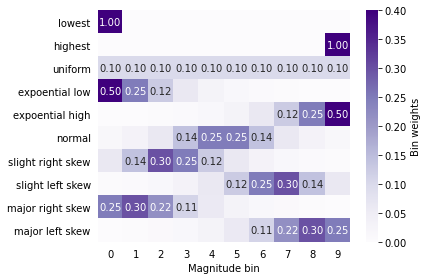

In [3]:
fig,ax = plt.subplots(1,1,figsize=(6,4))

t = np.array([weights for weights in SAMPLING_DISTRIBUTIONS.values()])

sbn.heatmap(t, cmap = "Purples", 
            vmax = 0.4,
            annot = t, fmt=".2f",
            cbar_kws={"label" : "Bin weights"})

ax.set_xlabel("Magnitude bin")

ax.set_yticklabels([weights.replace("_"," ") for weights in SAMPLING_DISTRIBUTIONS.keys()], rotation = 0);

# If percentage is less than 0.10, set text to be invisible
for text in ax.texts:
    if float(text.get_text()) < 0.10:
        text.set_visible(False)

# Remove bottom and left ticks
ax.tick_params(left=False, bottom=False)
        
plt.tight_layout()
plt.savefig("NegativeSamplingBinWeights.png", dpi = 300)

# Load data and take difference magnitudes

In [3]:
def generate_all_combos(list1, list2, list_limit = None):
    """
    Returns all combinations of items in two input lists
    
    ex)
    ---
    >>> x = [1,2,3]
    >>> y = ['x','y']
    >>> generate_all_combos(x,y)
    [(1, 'x'), (1, 'y'), (2, 'x'), (2, 'y'), (3, 'x'), (3, 'y')]
    """
    return [(i,j) for i in list1[:list_limit] for j in list2[:list_limit]]

In [4]:
# Load swissprot and RNAInter
# Take all protein combos

from Bio import SeqIO

# SWISS_PATH = "../Data/RawData/uniprot_sprot.fasta"

reduced_positive_df = pd.read_csv("../Data/TrainingData/PositiveSamples/reduced_RNAInter_small_interactions_current.csv")

# with open(SWISS_PATH) as handle:
#     swiss_fasta = [record for record in SeqIO.parse(handle, 'fasta') if len(record.seq) <= 110]

# swiss = [" ".join(protein) for protein in filter_sequences_by_len_from_fasta(SWISS_PATH, 110)]
# reduced_positive_prot_seqs = 

In [5]:
len(reduced_positive_df)

4876

In [6]:
class RNAInterIDConverter:
    """
    RNAInterIDConverter is designed to X
    """
    
    def __init__(self, seed):
        self.seed = seed
        self._taken_names = list()
    
    def clear_taken_names(self):
        self._taken_names = list()
    
    def get_uniprot_id_from_seq(self, df, protein_seq):
        return df[df['proteins'] == protein_seq]['UniprotID'].iloc[0]
    
    def get_random_rna_id(self, rna_names : pd.Series):
        shuffled_names = rna_names.sample(frac = 1, random_state = self.seed)
        
        for i in range(len(shuffled_names)):
            
            if shuffled_names.iloc[i] not in self._taken_names:
                name = shuffled_names.iloc[i]
                self._taken_names.append(name)
                return name
            
            # If it's the final entry, just use that
            elif i == len(shuffled_names)-1:
                return shuffled_names.iloc[i]
        
    def get_rna_id_from_seq(self, df, seq):
        self.clear_taken_names()
        rna_ids = df[df['proteins'] == seq]['RNA_Name']
        random_rna_id = self.get_random_rna_id(rna_ids)
        return random_rna_id
        
    def get_rna_and_unirpot_id_from_seq(self, df, seq):
        return (self.get_uniprot_id_from_seq(df, seq), self.get_rna_id_from_seq(df, seq))
    
    def get_unique_protein_uniprot_ids_and_rna_pair_from_df(self, df : pd.DataFrame):
        unique_seqs    = df['proteins'].unique()
        unique_protein_ids = [self.get_rna_and_unirpot_id_from_seq(df, protein_seq) for protein_seq in unique_seqs]
        return unique_protein_ids

In [7]:
rnainter_idconverter = RNAInterIDConverter(seed = 255)
rnainter_protein_rna_pairs = rnainter_idconverter.get_unique_protein_uniprot_ids_and_rna_pair_from_df(reduced_positive_df)
uniprot2rnaname = dict(rnainter_protein_rna_pairs)

In [7]:
class RNAInterRNACovnerter:
    """
    Generates the dictionary that converts RNA names to
    their encoded sequences
    """
    
    def encode_sequences(self, rna_seqs, embedder):
        return embedder(rna_seqs)
    
    def generate_rna_name_to_embedded_seq_converter(self, rna_names, embedded_seqs):
        return dict(zip(rna_names, embedded_seqs))
    
    def generate_rna_name_to_encoded_tensor_dict(self, rna_names, rna_seqs, embedder):
        embedded_seqs  = self.encode_sequences(rna_seqs, embedder)
        converter_dict = self.generate_rna_name_to_embedded_seq_converter(rna_names, embedded_seqs)
        return converter_dict
    
    def find_rna_seq_from_name(self, rna_name, df):
        return df[df['RNA_Name'] == rna_name]['rnas'].iloc[0]
    
    def return_rna_seqs_from_names(self, rna_names, df):
        return [self.find_rna_seq_from_name(rna_name, df) for rna_name in rna_names]
    
    def generate_rna_name_to_encoded_tensor_dict_from_df(self, rna_names, df, embedder):
        rna_seqs       = self.return_rna_seqs_from_names(rna_names, df)
        # print(list(rna_seqs))
        converter_dict = self.generate_rna_name_to_encoded_tensor_dict(rna_names, list(rna_seqs), embedder)
        return converter_dict

In [9]:
rnainter_rna_to_tensor_converter = RNAInterRNACovnerter()

rna_embedder = SkipGramEmbedder("../SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = True)
rna_embedder_2d = SkipGramEmbedder("../SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = False, outsize = 100)

rnaname2tensor = rnainter_rna_to_tensor_converter.generate_rna_name_to_encoded_tensor_dict_from_df(uniprot2rnaname.values(), reduced_positive_df, rna_embedder)
rnaname2tensor_2d = rnainter_rna_to_tensor_converter.generate_rna_name_to_encoded_tensor_dict_from_df(uniprot2rnaname.values(), reduced_positive_df, rna_embedder_2d)

In [10]:
#########
# 2D test?
#########
# rna_embedder_2d = SkipGramEmbedder("../SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = False)
# rnaname2tensor = rnainter_rna_to_tensor_converter.generate_rna_name_to_encoded_tensor_dict_from_df(uniprot2rnaname.values(), reduced_positive_df, rna_embedder)

In [8]:
class SwissIdCovnerter:
    """
    Generates the dictionary that converts Swiss names to
    their encoded sequences
    """
    
    def encode_sequences(self, rna_seqs, embedder):
        return embedder(rna_seqs)
    
    def generate_rna_name_to_embedded_seq_converter(self, rna_names, embedded_seqs):
        return dict(zip(rna_names, embedded_seqs))
    
    def generate_rna_name_to_encoded_tensor_dict(self, rna_names, rna_seqs, embedder):
        embedded_seqs  = self.encode_sequences(rna_seqs, embedder)
        converter_dict = self.generate_rna_name_to_embedded_seq_converter(rna_names, embedded_seqs)
        return converter_dict
    
    def find_rna_seq_from_name(self, rna_name, df):
        return df[df['RNA_Name'] == rna_name]['rnas'].iloc[0]
    
    def return_rna_seqs_from_names(self, rna_names, df):
        return [self.find_rna_seq_from_name(rna_name, df) for rna_name in rna_names]
    
    def generate_swiss_name_to_encoded_tensor_dict_from_df(self, rna_names, df, embedder):
        rna_seqs       = self.return_rna_seqs_from_names(rna_names, df)
        # print(list(rna_seqs))
        converter_dict = self.generate_rna_name_to_encoded_tensor_dict(rna_names, list(rna_seqs), embedder)
        return converter_dict

In [12]:
unique_proteins = reduced_positive_df['proteins'].unique()
# unique_proteins

In [13]:
x = reduced_positive_df.groupby("rnas").first()
x.shape

(1497, 13)

In [14]:
grouped_df = reduced_positive_df.groupby("proteins").first()
first_values = grouped_df.reset_index()

unique_reduced_rnainter_uniprot_ids = first_values['UniprotID'].unique()
unique_proteins = first_values['proteins']

print(len(unique_reduced_rnainter_uniprot_ids))
print(len(unique_proteins))

292
292


In [15]:
# unique_proteins.apply(lambda x: "".join(x))[]

In [16]:
# proteins, tokenizer, model, chunksize, max_len, cuda = True):
model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

swiss_embedder = IterableProteinEmbedding(swiss, tokenizer, model, chunksize = 3, max_len = 110, cuda = True)

# Need sorted set to make a reproducable set initialization for redoing stuff
from Utils.encoders import ProtBERTEmbedder
from Utils.encoders import ProtBERTEmbedder

rnainter_prot_embedder = ProtBERTEmbedder(112,True)
print(rnainter_prot_embedder.model.training)

rnainter_prot_embedder_2d = IterableProteinEmbedding(unique_proteins, tokenizer, model, chunksize = 3, max_len = 110, reduce = False, cuda = True)

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


NameError: name 'swiss' is not defined

In [17]:
swiss_ids = [swiss_id[0] for swiss_id in np.load("../Data/EncodedData/reduced_ProtBERT_encoded_110_swissprot_v2_names.npy")]
swiss_ids_2d = [swiss_id for swiss_id in np.load("../Data/EncodedData/reduced_ProtBERT_2dim_encoded_110_swissprot_names.npy")]

In [18]:
import os

# x
SWISS_EMBEDDED_PATH = "../Data/EncodedData/reduced_ProtBERT_encoded_110_swissprot_v2.pt"
SWISS_EMBEDDED_PATH_2D =  "../Data/EncodedData/reduced_ProtBERT_2dim_encoded_110_swissprot.pt"

if not os.path.exists(SWISS_EMBEDDED_PATH):
    with torch.no_grad():
        swiss_embedded = torch.cat([i for i in swiss_embedder])
    torch.save(swiss_embedded, SWISS_EMBEDDED_PATH)
else:
    swiss_embedded = torch.load(SWISS_EMBEDDED_PATH)
    

# swiss_embedded_2d = torch.load(SWISS_EMBEDDED_PATH_2D)

In [19]:
swiss_embedded.shape

torch.Size([9164, 1024])

In [20]:
len(swiss_ids)

9164

In [21]:
# Swiss uniptot IDs linked to their corresponding tensors
swiss2tensor = dict(zip(swiss_ids, swiss_embedded))
# swiss2tensor_2d = dict(zip(swiss_ids_2d, swiss_embedded_2d))

In [22]:
# rnainter_embedded = torch.cat([i for i in rnainter_prot_embedder])
# rnainter_embedded

In [23]:
# len(rnainter_embedded) == len(reduced_positive_df['proteins'].unique())

In [9]:
class ComboDifferenceIterator:
    """
    
    """
    def __init__(self, seq_matrix1, seq_matrix2, model, chunksize, limit = None):
        self.seq_matrix1 = seq_matrix1
        self.seq_matrix2 = seq_matrix2
        self.model = model
        
        assert chunksize > 1, f"ComboIterator fails when chunksize is less than 2. recieved chunksize: {chunksize}"
        self.chunksize = chunksize
        self.limit = limit
    
    def _format_matrix_for_sae_diff(self, combo):
        return torch.stack(combo)
    
    def format_combos_for_sae_diff(self, combos):
        combo1, combo2 = zip(*combos)
        combo1 = self._format_matrix_for_sae_diff(combo1)
        combo2 = self._format_matrix_for_sae_diff(combo2)
        return combo1, combo2
    
    def __iter__(self):
        
        combos = generate_all_combos(self.seq_matrix1, self.seq_matrix2, list_limit = self.limit)
        
        for i in tqdm(range(0,len(combos),self.chunksize)):
            combo1, combo2 = self.format_combos_for_sae_diff(combos[i:i+self.chunksize])
            
            reduced_combo1 = self.model(combo1)
            reduced_combo2 = self.model(combo2)
            
            combo_len = len(reduced_combo1)
            
            difference_magnitude = magnitude(reduced_combo1 - reduced_combo2).reshape(combo_len, 1)
            
            yield difference_magnitude

In [25]:
SAE_DIR  = '/data/Chapter_3/Notebooks'
rna_sae  = torch.load(f"{SAE_DIR}/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt")
prot_sae = torch.load(f"{SAE_DIR}/ProtBERT_encoded_110_swissprot_DenseSAE.pt")

In [26]:
protein_combo_iterator = ComboDifferenceIterator(rnainter_embedded, swiss_embedded.cuda(), prot_sae.cuda(), 2)

NameError: name 'rnainter_embedded' is not defined

In [27]:
DIFFERENCE_MATRIX = "../Data/EncodedData/Difference_Magnitude_ProtBERT_encoded_110_swissprot_v2_and_Unique_RNAInter_Proteins.pt"

if not os.path.exists(DIFFERENCE_MATRIX):
    protein_combo_magnitudes = torch.cat([i for i in protein_combo_iterator])
    torch.save(protein_combo_magnitudes, DIFFERENCE_MATRIX)
else:
    protein_combo_magnitudes = torch.load(DIFFERENCE_MATRIX)

# protein_combo_magnitudes = torch.cat([i for i in protein_combo_iterator])

In [28]:
protein_combo_magnitudes.shape

torch.Size([2675888, 1])

In [29]:
combo_ids = generate_all_combos(unique_reduced_rnainter_uniprot_ids, swiss_ids)
len(combo_ids)

2675888

In [30]:
bin_assigner = KBinsDiscretizer(n_bins=10, encode='ordinal')
bins         = bin_assigner.fit_transform(protein_combo_magnitudes.cpu()).squeeze().astype(int)

In [31]:
def plot_bin_and_diff_magnitudes(bins, protein_combo_magnitudes, ax):
    sbn.boxplot(x = bins, y = np.array( protein_combo_magnitudes.cpu().squeeze()), showfliers = False, 
                linewidth = 1.3, ax = ax)
    ax.set_ylabel("Difference magnitude")
    ax.set_xlabel("Bins")

def plot_combo_magnitude_dist(protein_combo_magnitudes, ax):
    sbn.histplot(protein_combo_magnitudes.cpu(), legend = False, ax = ax)
    ax.set_xlabel("Difference magnitude")

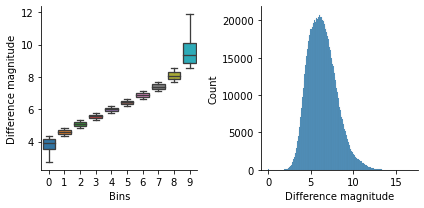

In [32]:
fig,axes = plt.subplots(1,2, figsize = (6,3))

# sbn.boxplot(x = bins, y = np.array( protein_combo_magnitudes.cpu().squeeze()), ax = axes[0])
# sbn.histplot(protein_combo_magnitudes.cpu(), legend = False, ax = axes[1])

# axes[0].set_ylabel("Difference magnitude")
# axes[0].set_xlabel("Bins")
# axes[1].set_xlabel("Difference magnitude")

plot_bin_and_diff_magnitudes(bins, protein_combo_magnitudes, axes[0])
plot_combo_magnitude_dist(protein_combo_magnitudes, axes[1])

plt.tight_layout()
sbn.despine()

plt.savefig("bin_and_diff_magnitude.png",dpi = 300)

# Sample protein pairs using difference magnitudes

In [10]:
class NegativeSampleIdxGenerator():
    """
    NegativeSampleIdxGenerator is used to assign negative sample 
    indeces using assigned bins and bin weights. This is meant 
    to be used for protein difference vector magnitudes, but can 
    be applied for any dataset that is assigned into bins and
    have bin weights.Can be used on its own, but is primarily 
    intended to be used within the <TBD> class. 
    
    It has two main functions:
    
    ####################################################
    generate_negative_sample_idxs_from_sample_weights
    ####################################################
    This will generate a list of negative indecies from a list
    of weights from each sample and a number of desired samples
    
    ###########################################
    generate_negative_sample_idxs_from_bins
    ###########################################
    This will generate a list of negative indecies using a list of
    bins that each sample is in, each bin's specific weight, and a
    number of desired samples. This converts each sample's bin
    assignment into a sample weight where the 
    generate_negative_sample_idxs_from_sample_weights method is
    then run
    """
    
    def __init__(self, seed):
        self.seed = seed
    
    def _generate_weight_assigner(self, bin_weights):
        return dict(zip(range(len(bin_weights)), bin_weights))
    
    def _convert_bins_to_weights(self, bins, bin_weights):
        weight_assigner = self._generate_weight_assigner(bin_weights)
        sample_weights = pd.Series(bins).apply(lambda x: weight_assigner[x])
        return sample_weights
    
    def generate_negative_sample_idxs_from_sample_weights(self, sample_weights, sample_count):
        torch.manual_seed(self.seed)
        negative_pair_idx = list(WeightedRandomSampler(sample_weights, sample_count, replacement=False))
        return negative_pair_idx
    
    def generate_negative_sample_idxs_from_bins(self, bins, bin_weights, sample_count):
        sample_weights = self._convert_bins_to_weights(bins, bin_weights)
        negative_pair_idx = self.generate_negative_sample_idxs_from_sample_weights(sample_weights, sample_count)
        return negative_pair_idx

In [11]:
SAMPLING_DISTRIBUTIONS.keys()

dict_keys(['lowest', 'highest', 'uniform', 'expoential_low', 'expoential_high', 'normal', 'slight_right_skew', 'slight_left_skew', 'major_right_skew', 'major_left_skew'])

In [12]:
SAMPLING_DISTRIBUTIONS['highest']

[0, 0, 0, 0, 0, 0, 0, 0, 0, 1]

In [13]:
def get_rna_partner_from_rnainter_uniprot_id(uniprot_id : str) -> torch.tensor:
    rna_partner_name = uniprot2rnaname[uniprot_id]
    # encoded_rna_partner = rnaname2tensor[rna_partner_name] # 1Dim
    encoded_rna_partner = rnaname2tensor_2d[rna_partner_name] # 2Dim
    return encoded_rna_partner

In [14]:
def get_new_encoded_swiss_partner_from_rnainter_uniprot_id(rnainter_swiss_id_pair: tuple) -> torch.tensor:
    _, swiss_id = rnainter_swiss_id_pair
    # encoded_swiss_seq = swiss2tensor[swiss_id] # 1Dim
    encoded_swiss_seq = swiss2tensor_2d[swiss_id] #2Dim
    return encoded_swiss_seq

In [15]:
def return_positive_samples(df, rna_embedder, reduce = True):
    model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
    tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

    rnainter_prot_embedder = IterableProteinEmbedding(df['proteins'], tokenizer, model, chunksize = 3, max_len = 110, reduce = reduce, cuda = True)
    encoded_rnainter_prots = torch.cat([encoded_prot for encoded_prot in rnainter_prot_embedder])

    encoded_rnainter_rnas = rna_embedder(df['rnas'])
    interaction = torch.ones(len(df))

    return encoded_rnainter_prots, encoded_rnainter_rnas, interaction

In [16]:
from Bio import SeqIO

def generate_swiss2seq(negative_pairs, swiss_path):
    _, neg_swiss_ids = zip(*negative_pairs)
    neg_swiss_ids = set(swiss_ids)
    
    with open(swiss_path) as handle:
        swiss2seq = {record.description.split("|")[1] : " ".join(list(record.seq)) for record in SeqIO.parse(handle, 'fasta') if record.description.split("|")[1] in neg_swiss_ids}
        
    return swiss2seq

In [17]:
def return_negative_samples(negative_pairs, reduce):
    encoded_rnas = list()
    encoded_swiss_prots = list()
    non_interaction = torch.zeros(len(negative_pairs))
    
    for negative_pair in negative_pairs:

        encoded_rna = get_rna_partner_from_rnainter_uniprot_id(negative_pair[0])
        encoded_rnas.append(encoded_rna)

    model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
    tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)
    
    _, swiss_ids = zip(*negative_pairs)
    SWISS_PATH = "../Data/RawData/uniprot_sprot.fasta"
    swiss2seq = generate_swiss2seq(negative_pairs, SWISS_PATH)
    
    seqs = [swiss2seq[swiss_id] for swiss_id in swiss_ids]
    neg_swiss_embedder = IterableProteinEmbedding(seqs, tokenizer, model, chunksize = 3, max_len = 110, reduce = reduce, cuda = True)
    
    with torch.no_grad():
        encoded_swiss_prots = torch.cat(list(neg_swiss_embedder))

    encoded_rnas = torch.stack(encoded_rnas)
    # encoded_swiss_prots = torch.stack(encoded_swiss_prots)
    
    return encoded_swiss_prots, encoded_rnas, non_interaction

In [18]:
def return_positive_samples(df, rna_embedder, reduce = True):
    model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
    tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

    rnainter_prot_embedder = IterableProteinEmbedding(df['proteins'], tokenizer, model, chunksize = 3, max_len = 110, reduce = reduce, cuda = True)
    encoded_rnainter_prots = torch.cat([encoded_prot for encoded_prot in rnainter_prot_embedder])

    encoded_rnainter_rnas = rna_embedder(df['rnas'])
    interaction = torch.ones(len(df))

    return encoded_rnainter_prots, encoded_rnainter_rnas, interaction

In [19]:
class RPI1807_processor:
    """
    RPI1807 is currently as a csv, it must be processed into
    encoded data before being validated.
    """
    
    def __init__(self, rpi1807_csv_path, mode):
        assert mode in ['negative_samples','dl_prediction'], \
        'mode must either be in "negative_samples" or "dl_prediction" for LazyClassifier and DL model evaluation respectively'
        
        self.rpi1807_path = rpi1807_csv_path
        self.mode = mode
        
        self.rna_embedder = SkipGramEmbedder("../SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = True)
        self.data = pd.read_csv(rpi1807_csv_path)
        
        def truncate_rpi1807_sequences():
            short_rnas = self.data['rnas'].apply(len) <= 100
            short_proteins = self.data['proteins'].apply(len) <= 110
            self.data = self.data[short_rnas & short_proteins]
        
        truncate_rpi1807_sequences()
        
    def encode_rnas(self, rna_seqs) -> torch.Tensor:
        return self.rna_embedder(rna_seqs)
        
    def _preprocess_protein(self, protein_seq):
        return " ".join(list(protein_seq))
    
    def _preprocess_proteins(self, protein_seqs):
        return [self._preprocess_protein(seq) for seq in protein_seqs]
    
    def encode_proteins(self, prot_seqs) -> torch.Tensor:
        processed_proteins = self._preprocess_proteins(prot_seqs)
        # print(processed_proteins)
        model     = AutoModel.from_pretrained("Rostlab/prot_bert_bfd")
        tokenizer = AutoTokenizer.from_pretrained("Rostlab/prot_bert_bfd", do_lower_case = False)

        rpi1807_embedder = IterableProteinEmbedding(processed_proteins, tokenizer, model, chunksize = 3, max_len = 110, cuda = True)
        encoded_proteins = torch.cat([i for i in rpi1807_embedder])
        
        return encoded_proteins
        
    def process_rpi1807(self) -> tuple:
        encoded_proteins = self.encode_proteins(self.data['proteins']).cpu()
        encoded_rnas = self.encode_rnas(self.data['rnas']).cpu()
        interaction = torch.tensor(self.data['interacts'].values)
        
        processed_data = (encoded_proteins, encoded_rnas, interaction)
        
        if self.mode == 'negative_samples':
            processed_data = get_lazy_X_and_y_data(processed_data)
            
        return processed_data

In [20]:
def get_lazy_X_and_y_data(data):
    X_data = np.concatenate([np.array(i) for i in data[:2]], axis = 1)
    y_data = np.array(data[-1])
    
    return X_data, y_data

In [21]:
def isolate_split_data(data, idx):
    return [encoded[idx] for encoded in data]

In [22]:
# fig, ax = plt.subplots(1,1, figsize = (6,3))

# sbn.violinplot(data = models.iloc[:,:-1].melt(), x = 'variable', y = 'value', ax = ax, 
#                color = 'white')
# sbn.swarmplot(data = models.iloc[:,:-1].melt(), x = 'variable', y = 'value', 
#               palette="tab10", ax = ax)

# sbn.despine()

In [23]:
SAMPLING_DISTRIBUTIONS.keys()

dict_keys(['lowest', 'highest', 'uniform', 'expoential_low', 'expoential_high', 'normal', 'slight_right_skew', 'slight_left_skew', 'major_right_skew', 'major_left_skew'])

In [24]:
distributions = ['uniform', 'expoential_low', 'expoential_high', 'lowest', 'highest', 'normal', 
                 'slight_right_skew', 'slight_left_skew', 'major_right_skew', 'major_left_skew']

In [25]:
len(reduced_positive_df)

4876

Performing lowest sampling experiments...
[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]


NameError: name 'bins' is not defined

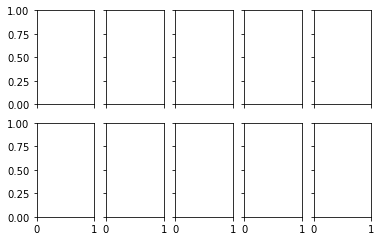

In [26]:
fig, axes = plt.subplots(2,5, figsize = (6,3.8), sharex = True, sharey = True)

i = 0

SEED = 255
SAMPLES = len(reduced_positive_df)

neg_idx_generator = NegativeSampleIdxGenerator(SEED)

neg_pair_idxs = list()

for i,distribution in enumerate(SAMPLING_DISTRIBUTIONS.keys()):
    print(f"Performing {distribution} sampling experiments...")
    bin_weights = SAMPLING_DISTRIBUTIONS[distribution]
    print(bin_weights)
    
    negative_pair_idx = neg_idx_generator.generate_negative_sample_idxs_from_bins(bins, bin_weights, SAMPLES)
    
    neg_pair_idxs.append(negative_pair_idx)
    
#     negative_pairs = np.array(combo_ids)[negative_pair_idx]
    
#     positive_samples = return_positive_samples(reduced_positive_df, rna_embedder)
#     negative_samples = return_negative_samples(negative_pairs)
    
#     data = [torch.cat([pos.cpu(),neg.cpu()]) for pos,neg in zip(*[positive_samples, negative_samples])]
    
# #     train_idx, test_idx = train_test_split(range(len(data[0])), random_state = 255, test_size = 0.2, 
# #                                         stratify = data[-1])
#      # test_idx, val_idx = train_test_split(test_idx, random_state = 255, test_size = 0.5,
# #                                      stratify = data[-1][test_idx])

#     rpi1807_processor = RPI1807_processor("../Data/EvaluationData/RPI1807.csv", mode = 'negative_samples')
    
#     x,y = rpi1807_processor.process_rpi1807()
    
#     X_train, y_train = get_lazy_X_and_y_data(data)
#     # X_test, y_test = get_lazy_X_and_y_data(train_data)
#     # X_test, y_test = get_lazy_X_and_y_data(test_data)
    
#     clf = LazyClassifier(random_state = 255)
#     models, _ = clf.fit(X_train, x, y_train, y)
    
#     models['distribution'] = distribution
    
    # models.to_csv(f"../PreTrainingExperimentResults/Lazypred{distribution}SamplingRPI1807Eval.csv")
    
    n = i>4
    k = i if i <= 4 else i - 5
    
    # axes[int(n),k].set_xlim(None,9)
    
#     if i == 1:
#         print(bins[negative_pair_idx])
#          t = bins[negative_pair_idx]
#          t.append(0)
    
    # Need to add one sample from each entry for visualization to prevent
    # a graphical glitch. This was NOT inlucded in negative sampling
    # experiments
    negative_sample_bins = np.append(bins[negative_pair_idx],np.arange(10))
    
    sbn.countplot(x = negative_sample_bins, ax = axes[int(n),k], 
                  palette = 'summer')
    
    
    # axes[int(n),k].set_title(distribution.replace('_','\n'))
    axes[int(n),k].set_ylabel("")

axes[0,0].set_xticks(range(0,10,3))
    
axes[0,0].set_ylabel("Sample count")
axes[1,0].set_ylabel("Sample count")

# axes[0,0].set_yticks(range(0,10,2))
# axes[0,0].set_yticklabels(list(np.linspace(0,1,5)))

# labels = axes[0,0].get_yticklabels()
# axes[0,0].set_yticklabels([round(i/len(bins[negative_pair_idx]),2) for label in labels])

axes[0,0].set_ylim(0,5000)

for i in range(5):
    axes[1,i].set_xlabel("Bin")

plt.tight_layout()
sbn.despine()

# plt.savefig("BinnedSampleCount.png", dpi = 300)

In [54]:
bin_weights = SAMPLING_DISTRIBUTIONS['slight_left_skew']
negative_pair_idx = neg_idx_generator.generate_negative_sample_idxs_from_bins(bins, bin_weights, SAMPLES)

negative_pairs = np.array(combo_ids)[negative_pair_idx]

positive_samples = return_positive_samples(reduced_positive_df, rna_embedder_2d, reduce = False)
negative_samples = return_negative_samples(negative_pairs, reduce = False)

# 2D Data
data = [torch.cat([pos.cpu(),neg.cpu()]) for pos,neg in zip(*[positive_samples, negative_samples])]

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1626 [00:00<?, ?it/s]

Some weights of the model checkpoint at Rostlab/prot_bert_bfd were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


  0%|          | 0/1626 [00:00<?, ?it/s]

In [55]:
# SAVE DISTRIBUTION DATA AS TUPLE
# Protein, RNA, interacts

import pickle

with open("../Data/TrainingData/ReducedEmbeddedTrainingData_2D.pickle",'wb') as outfile:
    pickle.dump(data, outfile)

# Evaluate combined experiments

In [25]:
combined_experiments = pd.concat([pd.read_csv(f"../PreTrainingExperimentResults/Lazypred{distribution}SamplingRPI1807Eval.csv") for distribution in SAMPLING_DISTRIBUTIONS.keys()]).reset_index(drop=True).round(5)

In [26]:
# All balanced accuracy and AUROC values are identical
print(f"AUROC and balanced accuracy are identical: {(combined_experiments['Balanced Accuracy'] == combined_experiments['ROC AUC']).all()}")

AUROC and balanced accuracy are identical: True


In [42]:
combined_experiments.groupby("Model").max().sort_values("Balanced Accuracy", ascending = False)[:5]

,Accuracy,Balanced Accuracy,ROC AUC,F1 Score,Time Taken,distribution
Model,,,,,,
LinearSVC,0.75,0.76,0.76,0.75,16.35,uniform
CalibratedClassifierCV,0.74,0.75,0.75,0.74,57.06,uniform
Perceptron,0.73,0.74,0.74,0.74,1.98,uniform
PassiveAggressiveClassifier,0.73,0.74,0.74,0.74,3.02,uniform
LogisticRegression,0.71,0.73,0.73,0.71,2.58,uniform


In [28]:
top_models = combined_experiments.groupby("Model").max().sort_values("Balanced Accuracy", ascending = False)[:5].index

print(f"""
TOP 5 PERFORMING MODELS:
{list(top_models)}
""")


TOP 5 PERFORMING MODELS:
['LinearSVC', 'CalibratedClassifierCV', 'Perceptron', 'PassiveAggressiveClassifier', 'LogisticRegression']



In [43]:
top_experiments = combined_experiments[ combined_experiments['Model'].isin(top_models) ]
top_experiment_data = top_experiments[['Model','Balanced Accuracy','ROC AUC','F1 Score','distribution']]
top_experiment_data

,Model,Balanced Accuracy,ROC AUC,F1 Score,distribution
2,LogisticRegression,0.66,0.66,0.63,lowest
11,PassiveAggressiveClassifier,0.57,0.57,0.49,lowest
22,LinearSVC,0.47,0.47,0.31,lowest
23,CalibratedClassifierCV,0.47,0.47,0.31,lowest
26,Perceptron,0.46,0.46,0.30,lowest
30,Perceptron,0.68,0.68,0.65,highest
32,PassiveAggressiveClassifier,0.66,0.66,0.64,highest
33,LogisticRegression,0.66,0.66,0.64,highest
35,LinearSVC,0.61,0.61,0.61,highest
37,CalibratedClassifierCV,0.60,0.60,0.60,highest


In [30]:
top_experiment_data.groupby("Model").max().sort_values("Balanced Accuracy", ascending = False)

,Balanced Accuracy,ROC AUC,F1 Score,distribution
Model,,,,
LinearSVC,0.76,0.76,0.75,uniform
CalibratedClassifierCV,0.75,0.75,0.74,uniform
PassiveAggressiveClassifier,0.74,0.74,0.74,uniform
Perceptron,0.74,0.74,0.74,uniform
LogisticRegression,0.73,0.73,0.71,uniform


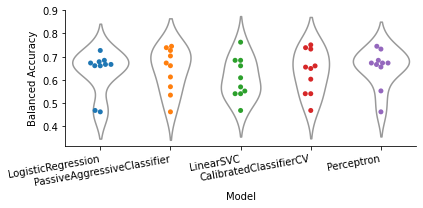

In [37]:
fig, ax = plt.subplots(1,1, figsize = (6,3))

# ADD MAX CLUSTERING

sbn.violinplot(data = top_experiments, x = 'Model', y = 'Balanced Accuracy', color = 'white', inner = None, ax = ax)
              # palette = "tab10", ax = ax)
    
sbn.swarmplot(data = top_experiments, x = 'Model', y = 'Balanced Accuracy',
              palette = "tab10", ax = ax)

ax.set_xticklabels(ax.get_xticklabels(), rotation = 10, ha = 'right')

sbn.despine()

plt.tight_layout()
plt.savefig("BestLazyPredModels.png", dpi = 300)

In [32]:
from functools import partial

partial_heatmap_data = partial(pd.pivot_table, top_experiment_data, index = 'distribution', columns='Model')
partial_clustermap_data = partial(pd.pivot_table, top_experiment_data, index = 'distribution', columns='Model')

In [33]:
partial_heatmap_data(values = 'Balanced Accuracy').loc[['slight_left_skew','normal','uniform','expoential_high','major_left_skew','highest','expoential_low','slight_right_skew','slight_right_skew','lowest'],:].mean(axis=1)

distribution
slight_left_skew    0.72
normal              0.70
uniform             0.69
expoential_high     0.67
major_left_skew     0.66
highest             0.64
expoential_low      0.63
slight_right_skew   0.58
slight_right_skew   0.58
lowest              0.53
dtype: float64

In [34]:
partial_heatmap_data(values = 'Balanced Accuracy').loc[['slight_left_skew','normal','uniform','expoential_high','major_left_skew','highest','expoential_low','slight_right_skew','slight_right_skew','lowest'],:]

Model,CalibratedClassifierCV,LinearSVC,LogisticRegression,PassiveAggressiveClassifier,Perceptron
distribution,,,,,
slight_left_skew,0.75,0.76,0.67,0.74,0.67
normal,0.74,0.68,0.68,0.74,0.67
uniform,0.73,0.57,0.68,0.73,0.74
expoential_high,0.65,0.68,0.67,0.70,0.66
major_left_skew,0.65,0.66,0.67,0.67,0.67
highest,0.60,0.61,0.66,0.66,0.68
expoential_low,0.54,0.54,0.73,0.61,0.73
slight_right_skew,0.66,0.55,0.47,0.53,0.67
slight_right_skew,0.66,0.55,0.47,0.53,0.67


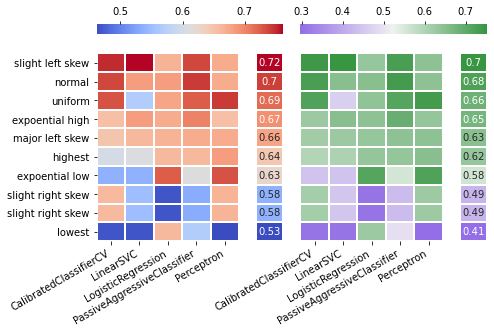

In [35]:
fig = plt.figure(figsize = (7,4))
gs = fig.add_gridspec(2,4, width_ratios=[0.42, 0.08, 0.42, 0.08], height_ratios=[0.05,0.95])

cbar1 = fig.add_subplot(gs[0,:2])
heatmap1 = fig.add_subplot(gs[1,0])
average1 = fig.add_subplot(gs[1,1])

cbar2 = fig.add_subplot(gs[0,2:])
heatmap2 = fig.add_subplot(gs[1,2])
average2 = fig.add_subplot(gs[1,-1])

sbn.heatmap(partial_heatmap_data(values = 'Balanced Accuracy').loc[['slight_left_skew','normal','uniform','expoential_high','major_left_skew','highest','expoential_low','slight_right_skew','slight_right_skew','lowest'],:], 
            linewidths=1, cmap="coolwarm", ax = heatmap1, cbar_ax = cbar1, cbar_kws = {'orientation': 'horizontal'})

sbn.heatmap(pd.DataFrame(partial_heatmap_data(values = 'Balanced Accuracy').loc[['slight_left_skew','normal','uniform','expoential_high','major_left_skew','highest','expoential_low','slight_right_skew','slight_right_skew','lowest'],:].mean(axis=1)), 
            linewidths=1, yticklabels = False, xticklabels = False, cbar = False, annot = True, cmap="coolwarm", ax = average1)

cbar1.xaxis.tick_top()

f1_cmap = sbn.diverging_palette(275, 130, s=80, l=55, as_cmap = True)

sbn.heatmap(partial_heatmap_data(values = 'F1 Score').loc[['slight_left_skew','normal','uniform','expoential_high','major_left_skew','highest','expoential_low','slight_right_skew','slight_right_skew','lowest'],:], 
            linewidths=1, yticklabels=False, cmap = f1_cmap, ax = heatmap2, cbar_ax = cbar2, cbar_kws = {'orientation': 'horizontal'})

sbn.heatmap(pd.DataFrame(partial_heatmap_data(values = 'F1 Score').loc[['slight_left_skew','normal','uniform','expoential_high','major_left_skew','highest','expoential_low','slight_right_skew','slight_right_skew','lowest'],:].mean(axis=1)), 
            linewidths=1, yticklabels = False, xticklabels = False, cbar = False, annot = True, cmap=f1_cmap, ax = average2)

cbar2.xaxis.tick_top()

for ax in [heatmap1,heatmap2]:
    ax.xaxis.set_ticklabels(ax.xaxis.get_ticklabels(), rotation = 30, ha = 'right');

heatmap1.yaxis.set_ticklabels([label.get_text().replace("_"," ") for label in heatmap1.yaxis.get_ticklabels()])

heatmap1.set_ylabel("")
average1.set_ylabel("")
average2.set_ylabel("")
heatmap2.set_ylabel("")

heatmap1.set_xlabel("")
heatmap2.set_xlabel("")

# Using plt.tight_layout() just ruins everything
# The rest of the modifications are made in PowerPoint
plt.savefig("OptimalNegativeSamplingStrategy.png", dpi = 300, bbox = "tight", pad_inches=0)

In [36]:
class NegativeSampleGenerator():
    """
    Difference magnitudes
    Swiss ID position in matrix
    RNAInter ID position in matrix
    
    Encoded RNAs: RNA RNAInter uniprot ID --> RNA partner name --> Encoded RNA
    Encoded Swiss proteins: 
    """
    
    def __init__(self, interaction_df, seed, n_bins, bin_weights, n_generated_samples):
        assert n_bins == len(bin_weights), "number of bins and bin weights must be identical"
        self.seed = seed
        self.n_bins = n_bins
        self.bin_weights = bin_weights
        self.n_generated_samples = n_generated_samples
        
        # Negative sample indecies generator
        self.negative_idx_generator = NegativeSampleIdxGenerator(self.seed)
        self.bin_assigner = KBinsDiscretizer(n_bins = self.n_bins, encode = 'ordinal')
        
        # rna_embedder = SkipGramEmbedder("../SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = True)
        
        def generate_rna_name2tensor(rna_embedder):
            rnainter_rna_to_tensor_converter = RNAInterRNACovnerter()
            rnaname2tensor = rnainter_rna_to_tensor_converter.generate_rna_name_to_encoded_tensor_dict_from_df(self.uniprot2rnaname.values(), reduced_positive_df, rna_embedder)
            return rnaname2tensor
        
#         rnainter_idconverter = RNAInterIDConverter(seed = 255)
#         rnainter_protein_rna_pairs = rnainter_idconverter.get_unique_protein_uniprot_ids_and_rna_pair_from_df(reduced_positive_df)
#         uniprot2rnaname = dict(rnainter_protein_rna_pairs)

        # Correct
        self.uniprot2rna_partner = dict(RNAInterRNACovnerter(self.seed).get_unique_protein_uniprot_ids_and_rna_pair_from_df(interaction_df))
        
        # Correct
        self.rnaname2tensor = generate_rna_name2tensor( SkipGramEmbedder("../SeqEmbedders/GensimWord2Vec/RNA2Vec_1024_hidden.model", reduce = True) )
        
        #
        self.rnainter_uniprot2swiss = 'test'
        self.swiss2tensor = 'test'
    
    def get_new_encoded_swiss_partner_from_rnainter_uniprot_id(rnainter_swiss_id_pair: tuple) -> torch.tensor:
        _, swiss_id = rnainter_swiss_id_pair
        encoded_swiss_seq = swiss2tensor[swiss_id]
        return encoded_swiss_seq
    
    def get_rna_partner_from_rnainter_uniprot_id(uniprot_id : str) -> torch.tensor:
        rna_partner_name = self.uniprot2rnaname[uniprot_id]
        encoded_rna_partner = self.rnaname2tensor[rna_partner_name]
        return encoded_rna_partner
    
    def return_negative_samples(negative_pairs):
        encoded_rnas = list()
        encoded_swiss_prots = list()
        non_interaction = torch.zeros(len(negative_pairs))

        for negative_pair in negative_pairs:
            encoded_rna = self.get_rna_partner_from_rnainter_uniprot_id(negative_pair[0])
            encoded_swiss_protein = self.get_new_encoded_swiss_partner_from_rnainter_uniprot_id(negative_pair)

            encoded_rnas.append(encoded_rna)
            encoded_swiss_prots.append(encoded_swiss_protein)

        encoded_rnas = torch.stack(encoded_rnas)
        encoded_swiss_prots = torch.stack(encoded_swiss_prots)

        return encoded_swiss_prots, encoded_rnas, non_interaction
    
    ##########################################################################
    def generate_negative_samples(self, difference_magnitudes, rnainter_ids, swiss_ids):
        assert len(difference_magnitudes) == len(rnainter_ids) == len(swiss_ids), \
        f"Difference magnitudes, RNAInter IDs and Swiss IDs need to be the same length Got {len(difference_magnitudes)}, {len(rnainter_ids)}, {len(swiss_ids)} entries for the difference magnitudes, RNAInter IDs, and Swiss IDs respectively"
        
        # Assign difference magnitudes into bins and generate the negative sample indeces
        bins = self.bin_assigner.fit_transform(difference_magnitudes).squeeze().astype(int)
        negative_sample_idxs = self.negative_idx_generator.generate_negative_sample_idxs_from_bins(bins, self.bin_weights, self.n_generated_samples)
        
        # Isolate X
        X = combos[negative_sample_idxs]
        self.negative_idx_generator(rnainter_ids)
        
        # 1. Generate negative sample IDs
        # 2. Isolate RNA and protein IDs for each position
        # 3. Convert RNAs --> vectors
        # 4. Swap RNAInter prot IDs w/ Swiss IDs --> vectors
        # 5. Add 0
        # return (prot tesnors, rna tensors, 0)
        pass

# Generate training data

In [55]:
# This is split anc concatted properly


In [56]:
# train_dataset = EncodedRPIDataset(train_data)
# val_dataset = EncodedRPIDataset(val_data)

# loaders = DataLoaders.from_dsets(train_dataset, val_dataset,
#                                  bs = 32,
#                                  device = 0)

# Train models using positive and negative data

Find package that automatically trains all the models using our training data

## Old "Train models using positive and negative data"

contains model optimization that handles default hyperparameter opt. I need to come back to this and make sure that
everything works

In [3]:
from torch.utils.data import Dataset

class EncodedRPIDataset(Dataset):
    def __init__(self, data):
        super().__init__()
        self.encoded_proteins = data[0]
        self.encoded_rnas = data[1]
        self.interaction = data[2]
    
    def __len__(self):
        return len(self.encoded_proteins)
    
    def __getitem__(self, idx):
        return self.encoded_proteins[idx], self.encoded_rnas[idx], self.interaction[idx]

In [4]:
import yaml

class DefaultHyperparameterHandler:
    """
    Nabbed from "data_handlers", put back in there when completed
    
    --------
    Designed to load default hyperparameters for a MainModel that has
    not been previously optimized through the nni wrapper. Assumes a
    model name of "RNA_{block}_Prot_{block}"
    
    Relies on the find_default_hyperparams funciton. This parses the
    default hyperparameters file for a given MainModel block name and
    returns the parameters for an RNA and Protein block in addition to 
    the default parameters used for the MainModel class. 
    """
    
    def __init__(self, default_hyperparam_path : str):
        self.file_name = default_hyperparam_path
        
#         def convert_act_strings_to_activations(default_params):
#             """
#             I finally get to use a recurrent function, yay!
#             ---
#             Recursively searches through the default parameters dictionaries
#             for pytorch activation function strings. Converts them to real
#             pytorch activation functions. 
#             """
#             for key, value in default_params.items():
#                 if type(value) is dict:
#                     convert_act_strings_to_activations(value)
#                 elif type(value) == str:
#                     if value[:3] == 'nn.':
#                         default_params[key] = eval(value)
        
        with open(default_hyperparam_path) as handle:
            self.default_params = yaml.load(handle, Loader = yaml.FullLoader)
            # convert_act_strings_to_activations(self.default_params)
            
    def _split_into_blocks(self, model_str : str) -> tuple:
        model_parts = model_str.split('_')
        rna_params, protein_params = model_parts[1], model_parts[3]
        return rna_params, protein_params
    
    def split_hyperparameters_into_blocks(self, rna_block_name : str, prot_block_name : str) -> tuple:
        
        assert rna_block_name in self.default_params.keys(), \
        f"RNA block name must be: {list(self.default_params.keys())}. Received {rna_block_name}"
        
        assert prot_block_name in self.default_params.keys(), \
        f"RNA block name must be: {list(self.default_params.keys())}. Received {prot_block_name}"
        
        main_params = self.default_params["MainModel"]
        rna_params  = self.default_params[rna_block_name]
        prot_params = self.default_params[prot_block_name]
    
        return main_params, rna_params, prot_params
        
    def find_default_hyperparams(self, model_name):
        ""
        rna_block_name, prot_block_name = self._split_into_blocks(model_name)
        main_params, prot_params, rna_params = self.split_hyperparameters_into_blocks(rna_block_name, prot_block_name)
        return main_params, prot_params, rna_params
        

In [5]:
with open("../Data/TrainingData/ReducedEmbeddedTrainingData_2D.pickle",'rb') as infile:
    data = pickle.load(infile)

In [6]:
data[1].shape

torch.Size([9752, 1024, 100])

In [7]:
# def MainModelHyperparameter:
#     """
    
#     """
    
#     def __init__(self, X):
#         pass
    
#     def

In [8]:
DEFAULT_HYPERPARAM_PATH = "../Data/ModelHyperparameters/DefaultHyperparameters.yaml"
default_hyperparam_handler = DefaultHyperparameterHandler(DEFAULT_HYPERPARAM_PATH)

In [9]:
default_hyperparam_handler.default_params

{'MainModel': {'batchsize': 32,
  'dense_hidden_layers': [5000, 3000, 1000, 500, 100, 50],
  'p': 0.3,
  'act': 'nn.LeakyReLU()',
  'bn': True},
 'Dense': {'hidden_layer_sizes': [80, 60, 40, 20],
  'bn': True,
  'p': 0.2,
  'act': 'nn.LeakyReLU()'},
 'ConvPool': {'conv_channel_sizes': [110, 20],
  'pooling_kernel_sizes': 2,
  'pooling_type': 'mixed',
  'mixed_a': 0.5,
  'ks': 3,
  'act_cls': 'nn.LeakyReLU()',
  'conv_kwargs': {'act_cls': 'nn.LeakyReLU()'},
  'pooling_kwargs': {'stride': 1}},
 'Reccurent': {'reccurent_type': 'LSTM',
  'bidirectional': True,
  'dropout': 0.3,
  'num_layers': 3,
  'hidden_size': 40},
 'Attention': {'layer_count': 16},
 'StackedRes': {'hidden_sizes': [100]}}

In [10]:
X = torch.rand(32,1024)
prot_Y = torch.rand(32,112,1024)
rna_Y  = torch.rand(32,100,1024)

In [11]:
# GOAL: swap last two tensors
x = torch.rand(23,100,20)
print(x.shape)
x = torch.swapaxes(x,-1,1)
print(x.shape)


torch.Size([23, 100, 20])
torch.Size([23, 20, 100])


In [12]:
from Utils.model_blocks import *

In [13]:
class BlockInputSizeCalculator:
    """
    
    """
    
    def __init__(self, max_rna_len, max_prot_len):
        self.max_rna_len = max_rna_len
        self.max_prot_len = max_prot_len

    def calculate_one_dim_block_input_sizes(self, block, input_tensor):
        if block not in ['ConvPool']:
            return 1024,1024
        else:
            return self.max_rna_len, self.max_prot_len
            
    def calculate_two_dim_block_input_sizes(self, block, input_tensor):
        if block not in ['ConvPool', 'Dense']:
            return 1024,1024
        
        if block == 'Dense':
            _, width, channel_length = input_tensor.shape
            dense_input_size = width * channel_length
            return dense_input_size
        else:
            return self.max_rna_len, self.max_prot_len
        
    def calculate_block_input_sizes(self, block, input_tensor):
        if len(input_tensor.shape) == 2:
            return self.calculate_one_dim_block_input_sizes(block, input_tensor)
        if len(input_tensor.shape) > 2:
            return self.calculate_two_dim_block_input_sizes(block, input_tensor)

In [14]:
import re

class BlockInializer:
    """
    Used to initialize blocks from a string.
    
    NOTE: This class is only used in this notebook
    """
    
    def _reformat_block_act(self, block_params):
        preprocessed_block_str = re.sub(r"'act': 'nn.(.+)\(\)'", r"'act': nn.\1()", block_params)
        return preprocessed_block_str
    
    def generate_block_str(self, block_name, input_size, block_params):
        return f"{block_name}Block({input_size}, **{block_params})"
    
    def initialize_block(self, block_name, input_size, block_params):
        block_str = self.generate_block_str(block_name, input_size, block_params)
        preprocessed_block_str = self._reformat_block_act(block_str)
        return eval(preprocessed_block_str)
    

In [15]:
from Utils.train import BlockInputShapeReformatter, MainModelDenseInputSizeCalculator

In [16]:
print(X.shape)
print(rna_Y.shape)
print(prot_Y.shape)

blocks = list(default_hyperparam_handler.default_params.keys())[1:]

torch.Size([32, 1024])
torch.Size([32, 100, 1024])
torch.Size([32, 112, 1024])


In [44]:
##########################################
# Test individual block creation
##########################################

for block in blocks:
    print(f"""
RNA: {block} | Prot: {block}
---""")
    
    _, rna_params, protein_params = default_hyperparam_handler.find_default_hyperparams(f"RNA_{block}_Protein_{block}")
    
    input_size_calculator = BlockInputSizeCalculator(max_rna_len = 100, max_prot_len = 110)
    block_initializer = BlockInializer()
    shape_reformatter = BlockInputShapeReformatter()
    
    if block == 'ConvPool':
        try:
            rna_input_size, prot_input_size = input_size_calculator.calculate_block_input_sizes(block, prot_Y)

            formatted_rna_input = shape_reformatter.reformat_input(block, rna_Y)
            formatted_prot_input = shape_reformatter.reformat_input(block, prot_Y)

            rna_block = block_initializer.initialize_block_from_str(block, rna_input_size, rna_params)
            prot_block = block_initializer.initialize_block_from_str(block, prot_input_size, protein_params)

            rna_block(formatted_rna_input)
            print("2D RNA Input success")

            prot_block(formatted_prot_input)
            print("2D Protein Input success")

        except:
            print(f"ERROR: {sys.exc_info()[1]}")
    
    try:
        rna_input_size, prot_input_size = input_size_calculator.calculate_block_input_sizes(block, X)
        
        formatted_input = shape_reformatter.reformat_input(block, X)
        
        rna_block = block_initializer.initialize_block_from_str(block, rna_input_size, rna_params)
        
#         if block == 'StackedRes':
#             print(rna_block)
            
        prot_block = block_initializer.initialize_block_from_str(block, prot_input_size, protein_params)
        
        rna_block(formatted_input)
        prot_block(formatted_input)
        print("1D Input success")
        
    except:
        print(f"ERROR: {sys.exc_info()[1]}")
    
    


RNA: Dense | Prot: Dense
---
ERROR: 'BlockInializer' object has no attribute 'initialize_block_from_str'

RNA: ConvPool | Prot: ConvPool
---
ERROR: 'BlockInializer' object has no attribute 'initialize_block_from_str'
ERROR: 'BlockInializer' object has no attribute 'initialize_block_from_str'

RNA: Reccurent | Prot: Reccurent
---
ERROR: 'BlockInializer' object has no attribute 'initialize_block_from_str'

RNA: Attention | Prot: Attention
---
ERROR: 'BlockInializer' object has no attribute 'initialize_block_from_str'

RNA: StackedRes | Prot: StackedRes
---
ERROR: 'BlockInializer' object has no attribute 'initialize_block_from_str'


In [45]:
###############################
# Test main model incorperation
###############################

# main_model_params, rna_params, protein_params = default_hyperparam_handler.find_default_hyperparams(f"RNA_{block}_Protein_{block}")

# BATCHSIZE = main_model_params.pop('batchsize')
# MAIN_ACT = eval(main_model_params.pop('act'))

for block in blocks:
    print(f"---\nRNA: {block} | Prot: {block}")
    _, rna_params, protein_params = default_hyperparam_handler.find_default_hyperparams(f"RNA_{block}_Protein_{block}")
    
    block_input_size_calculator = BlockInputSizeCalculator(max_rna_len = 100, max_prot_len = 110)
    block_initializer = BlockInializer()
    shape_reformatter = BlockInputShapeReformatter()
    
    try:
        rna_input_size, prot_input_size = block_input_size_calculator.calculate_block_input_sizes(block, X)
        
        formatted_input = shape_reformatter.reformat_input(block, X)
        
        rna_block = block_initializer.initialize_block(block, rna_input_size, rna_params)
        prot_block = block_initializer.initialize_block(block, prot_input_size, protein_params)
        
        input_calculator = InputSizeCalculator(formatted_input, formatted_input)
    
        input_size = input_calculator.calcualte_input_shape(rna_blocks  = [rna_block.cpu()], 
                                                            prot_blocks = [prot_block.cpu()])
        
        model = MainModel(rna_blocks  = [rna_block],
                          prot_blocks = [prot_block],
                          dense_input_size = input_size,
                          act = MAIN_ACT,
                          **main_model_params)
        
        model(formatted_input,formatted_input)
        
        print("Blocks passed through MainModel")
        
    except:
        print(f"ERROR: {sys.exc_info()[1]}")
    
#     if block == 'ConvPool':
#         try:
#             rna_input_size, prot_input_size = input_size_calculator.calculate_block_input_sizes(block, prot_Y)

#             formatted_rna_input = shape_reformatter.reformat_input(block, rna_Y)
#             formatted_prot_input = shape_reformatter.reformat_input(block, prot_Y)

#             rna_block = block_initializer.initialize_block_from_str(block, rna_input_size, rna_params)
#             prot_block = block_initializer.initialize_block_from_str(block, prot_input_size, protein_params)

#             rna_block(formatted_rna_input)
#             print("2D RNA Input success")

#             prot_block(formatted_prot_input)
#             print("2D Protein Input success")

#         except:
#             print(f"ERROR: {sys.exc_info()[1]}")

---
RNA: Dense | Prot: Dense
ERROR: name 'InputSizeCalculator' is not defined
---
RNA: ConvPool | Prot: ConvPool
ERROR: __init__() got multiple values for argument 'conv_channel_sizes'
---
RNA: Reccurent | Prot: Reccurent
ERROR: name 'InputSizeCalculator' is not defined
---
RNA: Attention | Prot: Attention
ERROR: name 'InputSizeCalculator' is not defined
---
RNA: StackedRes | Prot: StackedRes
ERROR: name 'InputSizeCalculator' is not defined


In [46]:
###############################
# Test 1D blocks invidiually
# 
# ConvPool is not applicable here
###############################

attention = AttentionBlock(1024, layer_count = 100)
attention(X)

print("Attention success")

reccurent = ReccurentBlock(1024, reccurent_type = 'LSTM', bidirectional = True, dropout = 0.3, num_layers = 3, hidden_size = 40)
reccurent(X.unsqueeze(1))

print("Reccurent success")

stackedres = StackedResBlock(1024, [100])
# print(stackedres)
stackedres(X.unsqueeze(-1));

print("StackedRes success")

dense = DenseBlock(1024, [500])
dense(X)

print("Dense success")

prot_sae_block = SAEBlock('Dense','/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt').cpu()
prot_sae_block(X)

print("DenseProtSAE success")

rna_sae_block = SAEBlock('Dense','/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt').cpu()
rna_sae_block(X)

print("DenseRNASAE success")

Attention success
Reccurent success
StackedRes success
Dense success
DenseProtSAE success
DenseRNASAE success


In [47]:
###############################
# Test 2D blocks invidiually
###############################

print("""Attention:
---""")
attention = AttentionBlock(112, layer_count = 10)
attention(prot_Y)
print("Prot success")

attention = AttentionBlock(100, layer_count = 10)
attention(rna_Y)
print("RNA success")


print("""
Reccurent:
---""")
reccurent = ReccurentBlock(1024, reccurent_type = 'LSTM', bidirectional = True, dropout = 0.3, num_layers = 3, hidden_size = 40)
reccurent(prot_Y)

print("Prot success")

reccurent = ReccurentBlock(1024, reccurent_type = 'LSTM', bidirectional = True, dropout = 0.3, num_layers = 3, hidden_size = 40)
reccurent(rna_Y)
print("RNA success")

print("""
ConvPool:
---""")
# NEEDSSS 2D INPUT, cannot be a restructured 1D input
# Input format as: Batchsize x Sequence position x Vector
convpool = ConvPoolBlock(conv_channel_sizes = [112,50,25], pooling_kernel_sizes = 2, pooling_type = 'mixed', mixed_a = 0.5)
convpool(prot_Y)
print("Prot success")

convpool = ConvPoolBlock(conv_channel_sizes = [100,50,25], 
                         pooling_kernel_sizes = 2, pooling_type = 'mixed', mixed_a = 0.5)
convpool(rna_Y)
print("RNA success")

print("""
StackedRes:
---""")
stackedres = StackedResBlock(112, [100])
stackedres(prot_Y);
print("Prot success")

stackedres = StackedResBlock(100, [100])
stackedres(rna_Y);
print("RNA success")

print("""
Dense:
---""")
dense = DenseBlock(1024*112, [500])
dense(prot_Y.reshape(32,1024*112))
print("Prot success")

dense = DenseBlock(1024*100, [500])
dense(rna_Y.reshape(32,1024*100))
print("RNA success")

####################################################
# Train Conv SAEs and then test
####################################################

# prot_sae_block = SAEBlock('Conv','/data/Chapter_3/Notebooks/ProtBERT_encoded_110_swissprot_DenseSAE.pt').cpu()
# prot_conv_sae_block(Y)

# rna_sae_block = SAEBlock('Conv','/data/Chapter_3/Notebooks/rnavec_encoded_aggregated_u_t_swapped_rnas_DenseSAE.pt').cpu()
# rna_conv_sae_block(Y)

Attention:
---
Prot success
RNA success

Reccurent:
---
Prot success
RNA success

ConvPool:
---
INPUT SHAPE: torch.Size([32, 112, 1024])
Prot success
INPUT SHAPE: torch.Size([32, 100, 1024])
RNA success

StackedRes:
---
Prot success
RNA success

Dense:
---
Prot success
RNA success


In [17]:
class ConvPoolBlock(nn.Module):
    "Try max pool, average pool, and average pool"
    
    def __init__(self, conv_channel_sizes, pooling_kernel_sizes, 
                 pooling_type, mixed_a = 0.5,
                 conv_kwargs = dict(), pool_kwargs = dict()):
        super().__init__()
        
        assert pooling_type in ['max','avg','mixed'] 
        assert len(conv_channel_sizes) >= 2
        
        if type(pooling_kernel_sizes) == int:
            self.pooling_kernel_sizes = [pooling_kernel_sizes for _ in range(len(conv_channel_sizes)-1)]
        
        self.conv_channel_sizes   = conv_channel_sizes
        
        assert 0 <= mixed_a <= 1, "mixed_a must be between 0 and 1"
        assert len(self.conv_channel_sizes)-1 == len(self.pooling_kernel_sizes), \
        "need equal number of conv_channel_sizes and pooling_kernel_sizes"
        
        self.pooling_type = pooling_type
        
        self.conv_kwargs = conv_kwargs
        self.pool_kwargs = pool_kwargs
        
        self.mixed_a = mixed_a
        
        self.pool = {'max'   : MaxPool,
                     'avg'   : AvgPool,
                     'mixed' : partial(MaxAvgPooling, a = self.mixed_a)}
        
        self.conv = nn.ModuleList([ConvLayer(self.conv_channel_sizes[i-1], self.conv_channel_sizes[i], ndim=1, **self.conv_kwargs) 
                                   for i in range(1, len(self.conv_channel_sizes))])
        
        self.pooling = nn.ModuleList([self.pool[self.pooling_type](kernel_size, ndim = 1, **self.pool_kwargs)
                                      for kernel_size in self.pooling_kernel_sizes])
        
    def forward(self, x):
        #print(f"INPUT SHAPE: {x.shape}")
        for i in range(len(self.conv)):
            x = self.conv[i](x)
            #print(f"CONV OUTPUT SHAPE: {x.shape}")
            x = self.pooling[i](x)
            #print(f"POOL OUTPUT SHAPE: {x.shape}")
            
        return x

In [28]:
# Mess around with ConvPool args to see what works best for arguments


convpool = ConvPoolBlock(conv_channel_sizes = [112,93,75,56,38,20], 
                         pooling_kernel_sizes = 2,
                         conv_kwargs = {'ks':5, 'act_cls':nn.LeakyReLU},
                         pooling_type = 'avg')

convpool(prot_Y)
print("Prot success")

# convpool(rna_Y)
# print("RNA success")
# convpool = ConvPoolBlock(conv_channel_sizes = [100,50,25], 
#                          pooling_kernel_sizes = 2, pooling_type = 'mixed', mixed_a = 0.5)
# convpool(rna_Y)
# print("RNA success")

INPUT SHAPE: torch.Size([32, 112, 1024])
CONV OUTPUT SHAPE: torch.Size([32, 93, 1024])
POOL OUTPUT SHAPE: torch.Size([32, 93, 512])
CONV OUTPUT SHAPE: torch.Size([32, 75, 512])
POOL OUTPUT SHAPE: torch.Size([32, 75, 256])
CONV OUTPUT SHAPE: torch.Size([32, 56, 256])
POOL OUTPUT SHAPE: torch.Size([32, 56, 128])
CONV OUTPUT SHAPE: torch.Size([32, 38, 128])
POOL OUTPUT SHAPE: torch.Size([32, 38, 64])
CONV OUTPUT SHAPE: torch.Size([32, 20, 64])
POOL OUTPUT SHAPE: torch.Size([32, 20, 32])
Prot success


In [73]:
np.linspace(112,20,3)

array([112.,  66.,  20.])

In [83]:
from torch.nn.modules.activation import *

In [84]:
protein_params

{'hidden_sizes': [100]}

In [85]:
BLOCK = blocks[3] 
initialize_default_block(BLOCK, 1024, default_hyperparam_handler.default_params[BLOCK])

NameError: name 'initialize_default_block' is not defined

In [86]:
prot_block = initialize_default_block("Dense", 1024, protein_params)

NameError: name 'initialize_default_block' is not defined

In [ ]:
prot_block

In [ ]:
protein_params

In [ ]:
#######################################################
# Initialize and train model (80-10-10 train-test-val)
#######################################################    
protein_block = initialize_default_block(X)
rna_block     = initialize_default_block(X)

In [87]:


# REPAIR INPUT CALCULATOR CLASS
# input_calculator = InputSizeCalculator()
input_size = input_calculator.calcualte_input_shape(rna_blocks  = [rna_block.cpu()], 
                                                    prot_blocks = [protein_block.cpu()])

model_model = MainModel(rna_blocks  = [rna_block],
                        prot_blocks = [protein_block],
                        dense_input_size = input_size,
                        dense_hidden_layers = [5000,2500,1250,625,322,161,80,40,20], 
                        p = 0.2,
                        act = nn.LeakyReLU()).cuda()

learner = Learner(loaders, model,
                  loss_func = nn.BCELoss(),
                  splitter = main_model_splitter,
                  model_dir = '.'
                  )

lr_min, lr_steep = learner.lr_find()
learner.fit_one_cycle(10, lr_max = slice(lr_steep, lr_min))

NameError: name 'input_calculator' is not defined

# Old, but might still be useful sometime

In [ ]:
import pandas as pd
from sklearn.preprocessing import KBinsDiscretizer
from torch.utils.data import WeightedRandomSampler
import torch

import random 

SEED = 255
POSITIVE_SAMPLES = 12161
PAIRS = round(POSITIVE_SAMPLES / 2)

In [ ]:
PAIRS

## FIRE negative scoring gradient sampling

In [88]:
SIMILARITY_FRAME_PATH = "../Data/TrainingData/NegativeSamples/small_interaction_similarity_frame.csv"
fire_df = pd.read_csv(SIMILARITY_FRAME_PATH)
fire_df

,uniprot1,uniprot2,seq_similarity,func_similarity,domain_similarity,similarity_score,species
0,P61014,Q30KN4,0.00,0.00,0.00,0.00,Mus musculus
1,Q9JHY3,P63213,0.00,0.00,0.00,0.00,Mus musculus
2,P35754,Q8N6N7,0.00,0.00,0.00,0.00,Homo sapiens
3,P35754,Q9NZ45,0.00,0.00,0.00,0.00,Homo sapiens
4,P35754,O14625,0.00,0.00,0.00,0.00,Homo sapiens
...,...,...,...,...,...,...,...
4190,P13500,P80098,0.74,0.30,1.00,0.68,Homo sapiens
4191,P51671,P80098,0.69,0.40,1.00,0.70,Homo sapiens
4192,P09341,P19876,0.87,0.50,1.00,0.79,Homo sapiens
4193,Q96FJ2,P63167,0.93,0.46,1.00,0.80,Homo sapiens


In [89]:
fire_df.sort_values('similarity_score', ascending=False).iloc[:3]

,uniprot1,uniprot2,seq_similarity,func_similarity,domain_similarity,similarity_score,species
4194,P61024,P33552,0.81,0.69,1.00,0.83,Homo sapiens
4193,Q96FJ2,P63167,0.93,0.46,1.00,0.80,Homo sapiens
4192,P09341,P19876,0.87,0.50,1.00,0.79,Homo sapiens


In [90]:
bin_assigner = KBinsDiscretizer(n_bins=10, encode='ordinal')
fire_bins    = bin_assigner.fit_transform(fire_df['similarity_score'].values.reshape(-1, 1) ).squeeze().astype(int)

In [91]:
def plot_kbin_data(df, x, y, ax, **kwargs):
    sbn.boxplot(x = x, y = y, data = df, ax = ax, **kwargs)
    ax.set_title("Score bins")
    ax.set_xlabel("bins")

In [92]:
def plot_score_distributions(df, x, score_bins, ax, **kwargs):
    sbn.histplot(x=x, hue=score_bins, data = df, ax = ax, **kwargs)
    ax.set_title("Score distribution")
    leg = ax.get_legend()
    leg.set_title("bins")

In [ ]:
fig, axes = plt.subplots(1,2, figsize = (6,3))

# fig.suptitle("FIRE similarity score quantile split")

plot_kbin_data(fire_df, fire_bins, "similarity_score", axes[0])
plot_score_distributions(fire_df, "similarity_score", fire_bins, axes[1])

plt.tight_layout()
sbn.despine()

# if FIGPATH:
#     plt.savefig(FIGPATH, dpi = 300)

The above graphs suggest that the dataset is so 0 heavy that it can't even be split into 10 quantiles. For the 4 quantiles it does generate, the score is so imbalanced that negative sampling wouldn't be viable here. 

## SAE vector-difference magnitude scoring gradient sampling

In [94]:
sae_df = pd.read_csv('../Data/TrainingData/NegativeSamples/latent_protein_pair_differences.csv')
sae_df.head()

,Protein_name,NCBI_GeneID,Protein_Type,Also_species,proteins,Protein_name.1,NCBI_GeneID.1,Protein_Type.1,Also_species.1,proteins.1,difference_magnitudes
0,RPL41,6171.00,protein,Homo sapiens,MRAKWRKKRMRRLKRKRRKMRQRSK,KRTAP19-1,337882.00,protein,Homo sapiens,MSHYGSYYGGLGYSCGGFGGLGYGYGCGCGSFCRRGSGCGYGGYGYGSGFGSYGYGSGFGGYGYGSGFGGYGYGCCRPSYNGGYGFSGFY,24.88
1,RPL41,6171.00,protein,Homo sapiens,MRAKWRKKRMRRLKRKRRKMRQRSK,KRTAP6-1,337966.00,protein,Homo sapiens,MCGSYYGNYYGTPGYGFCGYGGLGYGYGGLGCGYGSCCGCGFRRLGCGYGYGSRSLCGYGYGCGSGSGYYY,24.50
2,Lyrm7,75530.00,protein,Mus musculus,MGQPAKVLQLFKTLHRTRQQVFKNDKRALEAARVKINEEFKKHKNETSPEKIKEMMKLGSDVELLLRTAVIQGIHTDHDTLQLVPRKDLLTENVPYCDAPTQKQ,Prm1,19118.00,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,24.30
3,LYRM7,90624.00,protein,Homo sapiens,MGRAVKVLQLFKTLHRTRQQVFKNDARALEAARIKINEEFKNNKSETSSKKIEELMKIGSDVELLLRTSVIQGIHTDHNTLKLVPRKDLLVENVPYCDAPTQKQ,Prm1,19118.00,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,24.22
4,SRP9,6726.00,protein,Homo sapiens,MPQYQTWEEFSRAAEKLYLADPMKARVVLKYRHSDGNLCVKVTDDLVCLVYKTDQAQDVKKIEKFHSQLMRLMVAKEARNVTMETE,Prm1,19118.00,TF,Mus musculus,MARYRCCRSKSRSRCRRRRRRCRRRRRRCCRRRRRRCCRRRRSYTIRCKKY,24.10


In [77]:
sae_df.shape

(60726, 11)

In [78]:
bin_assigner = KBinsDiscretizer(n_bins=10, encode='ordinal')
sae_bins     = bin_assigner.fit_transform(sae_df['difference_magnitudes'].values.reshape(-1, 1) ).squeeze().astype(int)

In [79]:
generate_highest_or_lowest_samples(sae_df, 'difference_magnitudes', PAIRS, highest = False)

NameError: name 'generate_highest_or_lowest_samples' is not defined

In [ ]:
sae_df['bin'] = sae_bins

fig, axes = plt.subplots(2,4, figsize = (5,5), sharey = True, sharex = True)

i = 0

for distribution in SAMPLING_DISTRIBUTIONS.keys():
    
    n = i>3
    k = i if i <= 3 else i - 4
    
    WEIGHT_ASSIGNER = dict(zip(range(10), SAMPLING_DISTRIBUTIONS[distribution]))
    
    sae_df['weights'] = sae_df['bin'].apply(lambda x: WEIGHT_ASSIGNER[x])

    torch.manual_seed(SEED)
    negative_pair_idx = list(WeightedRandomSampler(sae_df['weights'], PAIRS, replacement=False))
    
    sbn.countplot(x = "bin", data = sae_df.iloc[negative_pair_idx], 
                  ax = axes[int(n),k], palette= 'summer')
    
    axes[int(n),k].set_title(distribution.replace('_','\n'))
    
    i += 1

plt.tight_layout()
sbn.despine()

In [ ]:
FIGPATH = "FIRE_and_SAE_scoring_distributions.png"

fig, axes = plt.subplots(2,2, figsize = (6,8))

PALETTE_ONE = 'Blues_r'
PALETTE_TWO = 'Greens'

plot_kbin_data(fire_df, fire_bins, "similarity_score", axes[0,0])
plot_score_distributions(fire_df, "similarity_score", fire_bins, axes[0,1], palette = PALETTE_ONE, bins = 50)

plot_kbin_data(sae_df, sae_bins, "difference_magnitudes", axes[1,0])
plot_score_distributions(sae_df, "difference_magnitudes", sae_bins, axes[1,1], palette = PALETTE_TWO)

axes[0,1].set_xlabel("FIRE similarity scores")
axes[1,1].set_xlabel("SAE difference magnitudes")

axes[0,1].set_ylim(None, 3000)
axes[1,1].set_ylim(None, 1800)
axes[0,0].set_ylabel("FIRE similarity scores")
axes[1,0].set_ylabel("SAE difference magnitudes")

sbn.despine()
plt.tight_layout()

if FIGPATH:
    plt.savefig(FIGPATH, dpi = 300)

In [80]:
pwd

'/data/Chapter_3/Notebooks'

In [ ]:
swaedxs